<a href="https://colab.research.google.com/github/DaraSamii/DataDays2021/blob/main/train_mix_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dara R Samii Login

In [ ]:
from google.colab import drive

drive.mount("/content/drive",force_remount=True)

%cd /content/drive/MyDrive/DataDays2021/

pwd = %pwd
pwd

Mounted at /content/drive
/content/drive/MyDrive/DataDays2021


'/content/drive/MyDrive/DataDays2021'

**-------------------------------------------------------------------------------------------------------------------------------**

# installing packages

In [ ]:
!pip install "dask[complete]"
!pip install -Uqq fastai
!pip install parsivar

     |████████████████████████████████| 776 kB 7.5 MB/s 
     |████████████████████████████████| 118 kB 68.3 MB/s 
     |████████████████████████████████| 769 kB 44.5 MB/s 
     |████████████████████████████████| 766 kB 80.2 MB/s 
     |████████████████████████████████| 1.0 MB 60.5 MB/s 
     |████████████████████████████████| 722 kB 60.1 MB/s 
     |████████████████████████████████| 722 kB 65.4 MB/s 
     |████████████████████████████████| 715 kB 74.4 MB/s 
     |████████████████████████████████| 705 kB 78.5 MB/s 
     |████████████████████████████████| 699 kB 79.7 MB/s 
     |████████████████████████████████| 696 kB 78.6 MB/s 
     |████████████████████████████████| 684 kB 26.4 MB/s 
     |████████████████████████████████| 679 kB 65.7 MB/s 
     |████████████████████████████████| 675 kB 63.8 MB/s 
     |████████████████████████████████| 675 kB 71.1 MB/s 
     |████████████████████████████████| 672 kB 67.6 MB/s 
     |████████████████████████████████| 671 kB 75.5 MB/s 
     |█████████

# Imports

In [ ]:
import dask.dataframe as dd
import pandas as pd
import os
from fastai.text.all import *
from fastai.tabular.all import *
import pickle

from torch.utils.data import Dataset
from tqdm import tqdm
import torch as T
from fastai.data.core import DataLoaders
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader

from helper import utils

# declaring paths

In [ ]:
data_folder = os.path.join(pwd,"data")
final_clicked = os.path.join(data_folder,"final","final_clicked.csv")
final_products = os.path.join(data_folder,"final","final_products.csv")
mix_model_path = os.path.join(data_folder,"models","mix_model")
category_classifier_path = os.path.join(data_folder,"models","category_classifier")

In [ ]:
cdf = dd.read_csv(final_clicked)
cdf.head()

,Unnamed: 0,rank,raw_query,page,product_showed,is_clicked,DAY(datetime),HOUR(datetime),IS_WEEKEND(datetime),MINUTE(datetime),MONTH(datetime),NUM_WORDS(raw_query),WEEKDAY(datetime),YEAR(datetime),products.category_name,products.product_name_normalized,products.sellers_count,products.availabilty_ratio,products.mean_all_price,products.max_all_price,products.min_all_price,products.std_all_price,products.skew_all_price,products.mean_available_price,products.max_available_price,products.min_available_price,products.std_available_price,products.skew_available_price,products.COUNT(clicked_merged),products.PERCENT_TRUE(clicked_merged.is_clicked),products.DAY(first_added_date),products.DAY(last_added_date),products.HOUR(first_added_date),products.HOUR(last_added_date),products.IS_WEEKEND(first_added_date),products.IS_WEEKEND(last_added_date),products.MINUTE(first_added_date),products.MINUTE(last_added_date),products.MONTH(first_added_date),products.MONTH(last_added_date),products.NUM_WORDS(product_name_normalized),products.WEEKDAY(first_added_date),products.WEEKDAY(last_added_date),products.YEAR(first_added_date),products.YEAR(last_added_date),_id
0,0,0,ماشین پژو پارس,0,mnlmg,False,14,5,False,33,4,3,2,2021,سایر لوازم تزئینی خودرو,پارس جلو پهن پژو اکورد طرح نیون چراغ اسپرت بلوری,1,1.0,810000.0,810000.0,810000.0,0.0,0.0,810000.0,810000.0,810000.0,0.0,0.0,31,0.032258,20,20,3,3,False,False,57,57,11,11,10,2,2,2019,2019,6312613
1,1,49,دامن شلواری,2,ydpvn,False,14,14,False,5,4,2,2,2021,شلوار و دامن زنانه,شلواری دامن راحت,1,0.0,599000.0,599000.0,599000.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1,0.000000,5,5,19,19,False,False,38,38,1,1,3,1,1,2021,2021,6313848
2,2,42,کفش چرم زنانه,1,micot,False,14,5,False,48,4,3,2,2021,کفش و صندل زنانه,کفش چرم طبی کد 428 معراج زنانه,1,1.0,470000.0,470000.0,470000.0,0.0,0.0,470000.0,470000.0,470000.0,0.0,0.0,4,0.000000,27,27,21,21,True,True,3,3,2,2,7,5,5,2021,2021,6314214
3,3,22,وافل ساز,2,mjtxs,False,13,21,False,23,4,2,1,2021,ساندویچ ساز و وافل ساز,صنعتی تخم ساز مرغی بست pfy 2 وافل,1,1.0,3500000.0,3500000.0,3500000.0,0.0,0.0,3500000.0,3500000.0,3500000.0,0.0,0.0,12,0.083333,2,2,10,10,True,True,26,26,1,1,8,5,5,2021,2021,6246255
4,4,22,وافل ساز,2,mjtxs,False,13,21,False,23,4,2,1,2021,ساندویچ ساز و وافل ساز,صنعتی تخم ساز مرغی بست pfy 2 وافل,1,1.0,3500000.0,3500000.0,3500000.0,0.0,0.0,3500000.0,3500000.0,3500000.0,0.0,0.0,12,0.083333,2,2,10,10,True,True,26,26,1,1,8,5,5,2021,2021,6246256


## loading vocab

In [ ]:
#if vocab exits:
vocab = pickle.load(open(os.path.join(category_classifier_path,"vocab"),'rb'))
vocab

(#2) [['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld', 'xxrep', 'xxwrep', 'xxup', 'xxmaj', '<', '>', '2', '1', 'startquery', 'endquery', 'startcategory', 'endcategory', 'و', 'گوشی', 'سایر', 'لوازم', '،', 'سامسونگ', 'بازی', 'جانبی', 'شیائومی', 'خودرو', 'ساعت', 'ماشین', 'مردانه', 'کیف', 'برقی', 'زنانه', 'کفش', 'لپ\u200cتاپ', 'تبلت', 'ابزار', 'برندهای', 'لباس', 'بادی', 'ساز', 'هدفون', 'کامپیوتر', 'اسباب', 'تجهیزات', 'کاور', 'تلویزیون', 'تفنگ', 'اپل', 'هوشمند', 'هدست', 'کنسول', 'یخچال', 'خواب', 'شارژی', 'کولر', 'هندزفری', 'کودک', 'ای', 'دستگاه', 'صندل', 'مودم', 'موبایل', 'هارد', 'سونی', 'آیفون', 'قاب', 'باتری', 'اسپیکر', 'ماسک', 'فریزر', 'بند', 'ایسوس', 'کیبورد', 'پی', 'چراغ', 'ساید', 'صندلی', 'ماوس', 'دوربین', 'ps4', 'دوچرخه', 'موتور', 'دخترانه', 'آشپزخانه', 'ظروف', 'ال', 'کارت', 'گازی', 'فلش', 'میز', 'poco', 'تاپ', '10', 'سرویس', 'روغن', 'پز', 'pro', 'جی', 'نوت', 'گل', 'کشتی', 'ورزشی', 'قطار', 'اسلایم', 'تخت', 'شارژر', 'اصلاح', 'note', 'اسکوتر', 'اسکیت', 'انواع', 'ایکس', 'آرایش', 'مچ', 'قطع

## nlp trasnforms pipeline

In [ ]:
class nlp_pipeline:
    def __init__(self, vocab,):
        self.vocab = vocab
        self.tok = SpacyTokenizer(lang='fa')
        self.num = Numericalize(vocab=self.vocab)

    def encode(self,x):
        x = utils._normalize_text(x)
        x = tokenize1(x, self.tok)
        x = self.num.encodes(x)
        return x

    def decode(self,x):
        x = self.num.decodes(x)
        x = " ".join(x)
        return x

In [ ]:
drop_cols =["Unnamed: 0",
            "product_showed",
            "DAY(datetime)",
            "HOUR(datetime)",
            "IS_WEEKEND(datetime)",
            "MINUTE(datetime)",
            "MONTH(datetime)",
            "WEEKDAY(datetime)",
            "YEAR(datetime)",
            "_id"]

cont_cols = ["rank",
             "NUM_WORDS(raw_query)",
             "page",
             "products.sellers_count",
             "products.availabilty_ratio",
             "products.mean_all_price",
             "products.max_all_price",
             "products.min_all_price",
             "products.std_all_price",
             "products.skew_all_price",
             "products.mean_available_price",
             "products.max_available_price",
             "products.min_available_price",
             "products.std_available_price",
             "products.skew_available_price",
             "products.COUNT(clicked_merged)",
             "products.PERCENT_TRUE(clicked_merged.is_clicked)",
             "products.NUM_WORDS(product_name_normalized)"]

cat_cols = ['products.DAY(first_added_date)',
            'products.DAY(last_added_date)',
            'products.HOUR(first_added_date)',
            'products.HOUR(last_added_date)',
            'products.IS_WEEKEND(first_added_date)',
            'products.IS_WEEKEND(last_added_date)',
            'products.MINUTE(first_added_date)',
            'products.MINUTE(last_added_date)',
            'products.MONTH(first_added_date)',
            'products.MONTH(last_added_date)',
            'products.WEEKDAY(first_added_date)',
            'products.WEEKDAY(last_added_date)',
            'products.YEAR(first_added_date)',
            'products.YEAR(last_added_date)']

text_col = ['raw_query',
            'products.category_name',
            'products.product_name_normalized',]

target = 'is_clicked'

In [ ]:
df = cdf.drop(drop_cols,axis=1).compute()
df

,rank,raw_query,page,is_clicked,NUM_WORDS(raw_query),products.category_name,products.product_name_normalized,products.sellers_count,products.availabilty_ratio,products.mean_all_price,products.max_all_price,products.min_all_price,products.std_all_price,products.skew_all_price,products.mean_available_price,products.max_available_price,products.min_available_price,products.std_available_price,products.skew_available_price,products.COUNT(clicked_merged),products.PERCENT_TRUE(clicked_merged.is_clicked),products.DAY(first_added_date),products.DAY(last_added_date),products.HOUR(first_added_date),products.HOUR(last_added_date),products.IS_WEEKEND(first_added_date),products.IS_WEEKEND(last_added_date),products.MINUTE(first_added_date),products.MINUTE(last_added_date),products.MONTH(first_added_date),products.MONTH(last_added_date),products.NUM_WORDS(product_name_normalized),products.WEEKDAY(first_added_date),products.WEEKDAY(last_added_date),products.YEAR(first_added_date),products.YEAR(last_added_date)
0,0,ماشین پژو پارس,0,False,3,سایر لوازم تزئینی خودرو,پارس جلو پهن پژو اکورد طرح نیون چراغ اسپرت بلوری,1,1.000000,8.100000e+05,810000.0,810000.0,0.000000e+00,0.000000,8.100000e+05,810000.0,810000.0,0.000000,0.000000,31,0.032258,20,20,3,3,False,False,57,57,11,11,10,2,2,2019,2019
1,49,دامن شلواری,2,False,2,شلوار و دامن زنانه,شلواری دامن راحت,1,0.000000,5.990000e+05,599000.0,599000.0,0.000000e+00,0.000000,NaN,NaN,NaN,NaN,NaN,1,0.000000,5,5,19,19,False,False,38,38,1,1,3,1,1,2021,2021
2,42,کفش چرم زنانه,1,False,3,کفش و صندل زنانه,کفش چرم طبی کد 428 معراج زنانه,1,1.000000,4.700000e+05,470000.0,470000.0,0.000000e+00,0.000000,4.700000e+05,470000.0,470000.0,0.000000,0.000000,4,0.000000,27,27,21,21,True,True,3,3,2,2,7,5,5,2021,2021
3,22,وافل ساز,2,False,2,ساندویچ ساز و وافل ساز,صنعتی تخم ساز مرغی بست pfy 2 وافل,1,1.000000,3.500000e+06,3500000.0,3500000.0,0.000000e+00,0.000000,3.500000e+06,3500000.0,3500000.0,0.000000,0.000000,12,0.083333,2,2,10,10,True,True,26,26,1,1,8,5,5,2021,2021
4,22,وافل ساز,2,False,2,ساندویچ ساز و وافل ساز,صنعتی تخم ساز مرغی بست pfy 2 وافل,1,1.000000,3.500000e+06,3500000.0,3500000.0,0.000000e+00,0.000000,3.500000e+06,3500000.0,3500000.0,0.000000,0.000000,12,0.083333,2,2,10,10,True,True,26,26,1,1,8,5,5,2021,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53668,49,کتونی دخترانه,4,False,2,کفش و صندل زنانه,دخترانه جذاب کتونی,1,0.000000,1.550000e+05,155000.0,155000.0,0.000000e+00,0.000000,NaN,NaN,NaN,NaN,NaN,2,0.000000,6,6,13,13,False,False,50,50,1,1,3,2,2,2021,2021
53669,2,تلویزیون ایکس ویژن,0,False,3,تلویزیون ایکس ویژن,49 49 size x vision xvision tv 49 اینچ ال xk 570 xvision 49 xk 570 کیفیت inch 49 xk 570 تلویزیون ایکس با full inches ویژن تلویزیون hd 49 xk 570 اچ ای ایکسویژن full tv دی مدل ایکس fhd فول ایکس سایز تصویر هوشمند led led 49 xk 570 اینچ ویژن,42,0.142857,7.232385e+06,38950000.0,0.0,5.809454e+06,3.610436,9.135833e+06,9685000.0,8800000.0,361344.902951,0.681049,92,0.108696,18,24,0,12,False,True,21,42,2,4,53,0,5,2019,2021
53670,9,ویدئو پروژکتور,0,False,2,سایر برندهای ویدیو پروژکتور,video ویدیو k 18 پرژکتور projector,1,1.000000,3.540000e+06,3540000.0,3540000.0,0.000000e+00,0.000000,3.540000e+06,3540000.0,3540000.0,0.000000,0.000000,96,0.031250,29,29,9,9,False,False,3,3,3,3,6,0,0,2021,2021
53671,9,ویدئو پروژکتور,0,False,2,سایر برندهای ویدیو پروژکتور,video ویدیو k 18 پرژکتور projector,1,1.000000,3.540000e+06,3540000.0,3540000.0,0.000000e+00,0.000000,3.540000e+06,3540000.0,3540000.0,0.000000,0.000000,96,0.031250,29,29,9,9,False,False,3,3,3,3,6,0,0,2021,2021


In [ ]:
class MixDataSet(Dataset):
    def __init__(self, df, cat_col_names, cont_col_names, query_col_name, category_col_name, product_col_name, vocab,target_col_name=None, test=False,normalize=True,):
        self.df = df.reset_index(drop=True).copy()
        self.cat_col_names = cat_col_names
        self.cont_col_names = cont_col_names
        self.query_col_name = query_col_name
        self.category_col_name = category_col_name
        self.product_col_name = product_col_name
        self.target_col_name = target_col_name


        self.test = test

        self.normalize = normalize

        self.vocab = vocab
        self.nlp_pipeline = nlp_pipeline(vocab=self.vocab)

        if self.test == False:
            self.target_col_name = target_col_name


    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, i):
        ndf = self.df.iloc[i]
        ndf = ndf.fillna(0.0,inplace=False)

        if self.normalize == True:
            if type(ndf) == pd.core.series.Series:
             for col in ndf.index:
                if "price" in col:
                    ndf[col] = np.log10(ndf[col]/1000 + 1)
                elif "NUM" in col or "COUNT" in col:
                    ndf[col] = np.log10(ndf[col] + 1)
           
            elif type(ndf) == pd.core.frame.DataFrame:
             for col in ndf.columns:
                if "price" in col:
                    ndf[col] = np.log10(ndf[col]/1000 + 1)
                elif "NUM" in col or "COUNT" in col:
                    ndf[col] = np.log10(ndf[col] + 1)

        for col in self.cat_col_names:
            if "YEAR" in col:
                ndf[col] = ndf[col] - 2017

            
        cat = ndf[self.cat_col_names].values

        cont = ndf[self.cont_col_names].values

        query = self.nlp_pipeline.encode(ndf[self.query_col_name])
        category = self.nlp_pipeline.encode(ndf[self.category_col_name])
        product = self.nlp_pipeline.encode(ndf[self.product_col_name])
        
        if self.test == False:
            target = ndf[self.target_col_name]
            return (T.tensor(cat.astype(np.int32)),T.tensor(cont.astype(np.float32)),query,category,product), T.tensor(target)
        else:
            return (T.tensor(cat.astype(np.int32)),T.tensor(cont.astype(np.float32)),query,category,product)


In [ ]:
stratified_df = pd.concat([df[df["is_clicked"] == True].reset_index(drop=True)[0:10000],
                           df[df["is_clicked"] == False].reset_index(drop=True)[0:10000]]).reset_index(drop=True).sample(frac=1)

In [ ]:
stratified_df.groupby(by="is_clicked").count()

,rank,raw_query,page,NUM_WORDS(raw_query),products.category_name,products.product_name_normalized,products.sellers_count,products.availabilty_ratio,products.mean_all_price,products.max_all_price,products.min_all_price,products.std_all_price,products.skew_all_price,products.mean_available_price,products.max_available_price,products.min_available_price,products.std_available_price,products.skew_available_price,products.COUNT(clicked_merged),products.PERCENT_TRUE(clicked_merged.is_clicked),products.DAY(first_added_date),products.DAY(last_added_date),products.HOUR(first_added_date),products.HOUR(last_added_date),products.IS_WEEKEND(first_added_date),products.IS_WEEKEND(last_added_date),products.MINUTE(first_added_date),products.MINUTE(last_added_date),products.MONTH(first_added_date),products.MONTH(last_added_date),products.NUM_WORDS(product_name_normalized),products.WEEKDAY(first_added_date),products.WEEKDAY(last_added_date),products.YEAR(first_added_date),products.YEAR(last_added_date)
is_clicked,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,9223,9223,9223,9223,9223,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
True,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,9112,9112,9112,9112,9112,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000


In [ ]:
b = MixDataSet(stratified_df,cat_cols,cont_cols,"raw_query","products.category_name","products.product_name_normalized",target_col_name="is_clicked",vocab=vocab[0])

In [ ]:
b[0:10]

In [ ]:
len(b)

20000

In [ ]:
stratified_df["is_valid"] = False
stratified_df["is_valid"] = stratified_df["is_valid"].apply(lambda x: True if random.random() < 0.08 else False)

In [ ]:
def my_collate(batch):
    b = list(zip(*batch))
    x,y = b
    x1,x2,x3,x4,x5 = list(zip(*x))

    return (T.stack(x1),T.stack(x2), nn.utils.rnn.pad_sequence(x3).T, nn.utils.rnn.pad_sequence(x4).T, nn.utils.rnn.pad_sequence(x5).T), T.stack(y).to(T.long)

In [ ]:
train_ds = MixDataSet(stratified_df[stratified_df["is_valid"]==False],
                      cat_cols,
                      cont_cols,
                      "raw_query",
                      "products.category_name",
                      "products.product_name_normalized",
                      target_col_name="is_clicked",
                      vocab=vocab[0])

valid_ds = MixDataSet(stratified_df[stratified_df["is_valid"]==True],
                      cat_cols,
                      cont_cols,
                      "raw_query",
                      "products.category_name",
                      "products.product_name_normalized",
                      target_col_name="is_clicked",
                      vocab = vocab[0])

In [ ]:
len(train_ds), len(valid_ds)

(18398, 1602)

In [ ]:
train_dl = DataLoader(dataset=train_ds, batch_size=150, shuffle=True, collate_fn=my_collate)
valid_dl = DataLoader(dataset=valid_ds, batch_size=150, shuffle=True, collate_fn=my_collate)

In [ ]:
next(iter(train_dl))

((tensor([[22, 22, 21,  ...,  2,  2,  2],
          [14, 12, 10,  ...,  2,  4,  4],
          [24, 12, 16,  ...,  2,  3,  4],
          ...,
          [17,  6,  7,  ...,  3,  3,  4],
          [ 1, 17,  1,  ...,  0,  3,  4],
          [ 9,  9, 21,  ...,  1,  4,  4]], dtype=torch.int32),
  tensor([[8.0000e+00, 3.0103e-01, 0.0000e+00,  ..., 1.8451e+00, 1.0145e-01,
           7.7815e-01],
          [0.0000e+00, 4.7712e-01, 0.0000e+00,  ..., 3.2060e+00, 8.9664e-02,
           1.4150e+00],
          [2.0000e+00, 3.0103e-01, 0.0000e+00,  ..., 2.9996e+00, 1.3527e-01,
           2.1875e+00],
          ...,
          [2.6000e+01, 4.7712e-01, 1.0000e+00,  ..., 2.0569e+00, 4.4248e-02,
           1.4914e+00],
          [2.0000e+00, 7.7815e-01, 0.0000e+00,  ..., 3.5145e+00, 1.3001e-01,
           2.2355e+00],
          [1.2500e+02, 6.9897e-01, 5.0000e+00,  ..., 6.9897e-01, 2.5000e-01,
           1.3979e+00]]),
  TensorText([[   2,  100,    0,  ...,    0,    0,    0],
          [   2,   27,   49,  .

In [ ]:
next(iter(valid_dl))

((tensor([[27,  9,  3,  ...,  5,  1,  4],
          [10, 10,  7,  ...,  0,  1,  1],
          [12,  1, 23,  ...,  5,  3,  4],
          ...,
          [ 3,  3, 18,  ...,  3,  3,  3],
          [25,  6, 11,  ...,  3,  2,  4],
          [24, 13, 14,  ...,  5,  3,  4]], dtype=torch.int32),
  tensor([[1.0000e+00, 4.7712e-01, 0.0000e+00,  ..., 1.6128e+00, 1.0000e-01,
           1.3979e+00],
          [2.7000e+01, 6.0206e-01, 1.0000e+00,  ..., 8.4510e-01, 0.0000e+00,
           9.5424e-01],
          [8.4200e+02, 6.9897e-01, 8.4000e+01,  ..., 9.0309e-01, 0.0000e+00,
           1.2304e+00],
          ...,
          [3.9000e+01, 3.0103e-01, 1.0000e+00,  ..., 4.7712e-01, 0.0000e+00,
           8.4510e-01],
          [0.0000e+00, 4.7712e-01, 0.0000e+00,  ..., 2.9096e+00, 6.5351e-02,
           1.9191e+00],
          [6.0000e+00, 4.7712e-01, 0.0000e+00,  ..., 2.9232e+00, 8.0048e-02,
           1.3222e+00]]),
  TensorText([[   2,  343,  138,  ...,    0,    0,    0],
          [   2,  367, 2474,  .

In [ ]:
class MixModel(nn.Module):
    def __init__(self, embed_sz, n_cont, layers, awd_config, vocab_sz, lin_ftrs,joint_layers):
        super(MixModel, self).__init__()

        self.embed_sz  = embed_sz
        self.n_cont = n_cont
        self.layers = layers
        self.awd_config = awd_config
        self.joint_layers = joint_layers

        self.tab_model = TabularModel(emb_szs=self.embed_sz, n_cont=n_cont, out_sz=2,layers=layers,)
        self.tab_model.layers = self.tab_model.layers[:-1]

        self.awd1 = get_text_classifier(AWD_LSTM,vocab_sz=vocab_sz, n_class=2, config=awd_config,lin_ftrs=lin_ftrs)
        self.awd1[-1].layers = self.awd1[-1].layers[:-1]

        self.awd2 = get_text_classifier(AWD_LSTM,vocab_sz=vocab_sz, n_class=2, config=awd_config,lin_ftrs=lin_ftrs)
        self.awd2[-1].layers = self.awd2[-1].layers[:-1]

        self.awd3 = get_text_classifier(AWD_LSTM,vocab_sz=vocab_sz, n_class=2, config=awd_config,lin_ftrs=lin_ftrs)
        self.awd3[-1].layers = self.awd3[-1].layers[:-1]

        self.joint_layers = [lin_ftrs[-1]*3 + layers[-1]] + joint_layers + [2]
        linBins = []
        for i in range(0,len(self.joint_layers)-1):
            linBins.append(LinBnDrop(self.joint_layers[i],self.joint_layers[i+1]))

        self.LinBins = nn.Sequential(*linBins)
        self.Softmax = nn.Softmax(dim=1)

    def forward(self, x):
        xtab = self.tab_model(x[0],x[1])
        xnlp1 = self.awd1(x[2])[0]
        xnlp2 = self.awd2(x[3])[0]
        xnlp3 = self.awd3(x[4])[0]

        X = T.cat([xtab, xnlp1, xnlp2, xnlp3],dim=1)
        X = self.LinBins(X)
        return self.Softmax(X)

    def reset(self):
        self.awd1.reset()
        self.awd2.reset()
        self.awd3.reset()

In [ ]:
for col in cat_cols:
    print(col,"-->", df[col].nunique())

products.DAY(first_added_date) --> 31
products.DAY(last_added_date) --> 31
products.HOUR(first_added_date) --> 24
products.HOUR(last_added_date) --> 24
products.IS_WEEKEND(first_added_date) --> 2
products.IS_WEEKEND(last_added_date) --> 2
products.MINUTE(first_added_date) --> 60
products.MINUTE(last_added_date) --> 60
products.MONTH(first_added_date) --> 12
products.MONTH(last_added_date) --> 12
products.WEEKDAY(first_added_date) --> 7
products.WEEKDAY(last_added_date) --> 7
products.YEAR(first_added_date) --> 5
products.YEAR(last_added_date) --> 5


In [ ]:
len(cont_cols)

18

In [ ]:
emb_sz = [
          (32, 20),
          (32, 20),
          (24, 20),
          (24, 20),
          (3, 10),
          (3, 10),
          (61, 30),
          (61, 30),
          (13, 10),
          (13, 10),
          (8, 10),
          (8, 10),
          (6, 20),
          (6, 20)
]

In [ ]:
awd_conf = {'bidir': True,
            'emb_sz': 1000,
            'embed_p': 0.05,
            'hidden_p': 0.3,
            'input_p': 0.4,
            'n_hid': 1000,
            'n_layers': 3,
            'output_p': 0.4,
            'pad_token': 1,
            'weight_p': 0.5}

In [ ]:
mix_model = MixModel(embed_sz = emb_sz, n_cont= len(cont_cols), layers=[200], awd_config=awd_conf, vocab_sz=len(vocab[0]), lin_ftrs=[500],joint_layers=[500])

In [ ]:
state_dict = T.load(open(os.path.join(mix_model_path,"models","mix_model.pth"),'rb'))
mix_model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
mix_model

In [ ]:
sum(p.numel() for p in mix_model.parameters())

93584056

In [ ]:
a = next(iter(train_dl))

In [ ]:
tab = mix_model.tab_model(a[0][0],a[0][1])
nlp1 = mix_model.awd1(a[0][2])
nlp2 = mix_model.awd2(a[0][3])
nlp3 = mix_model.awd3(a[0][4])

print(tab.shape, nlp1[0].shape, nlp2[0].shape, nlp3[0].shape)

torch.Size([30, 200]) torch.Size([30, 500]) torch.Size([30, 500]) torch.Size([30, 500])


In [ ]:
mix_model(a[0])

tensor([[0.7601, 0.2399],
        [0.3067, 0.6933],
        [0.4844, 0.5156],
        [0.5187, 0.4813],
        [0.5678, 0.4322],
        [0.3312, 0.6688],
        [0.4830, 0.5170],
        [0.3881, 0.6119],
        [0.3877, 0.6123],
        [0.2758, 0.7242],
        [0.3732, 0.6268],
        [0.1953, 0.8047],
        [0.2441, 0.7559],
        [0.7051, 0.2949],
        [0.4071, 0.5929],
        [0.6885, 0.3115],
        [0.3878, 0.6122],
        [0.7209, 0.2791],
        [0.4953, 0.5047],
        [0.3952, 0.6048],
        [0.3305, 0.6695],
        [0.2922, 0.7078],
        [0.2933, 0.7067],
        [0.5104, 0.4896],
        [0.4875, 0.5125],
        [0.7499, 0.2501],
        [0.8187, 0.1813],
        [0.8454, 0.1546],
        [0.8230, 0.1770],
        [0.5975, 0.4025]], grad_fn=<SoftmaxBackward>)

In [ ]:
fast_mix_dl = DataLoaders(train_dl,valid_dl)

In [ ]:
loss_func = nn.CrossEntropyLoss()

learn = Learner(fast_mix_dl,
                mix_model,
                loss_func = loss_func,
                path = mix_model_path,
                metrics=[accuracy,error_rate,Recall(),Precision(),F1Score()]).to_fp16()


In [ ]:
grp = ShowGraphCallback
svm = SaveModelCallback(at_end=False,every_epoch=False,reset_on_fit=False,monitor='f1_score',fname="mix_model",)
esc = EarlyStoppingCallback(patience=3)
rlr = ReduceLROnPlateau(monitor="valid_loss",patience=2,factor=10,)
learn.add_cbs([grp,svm,esc,rlr,ModelResetter])
learn.cbs

(#9) [TrainEvalCallback,Recorder,ProgressCallback,MixedPrecision,ShowGraphCallback,SaveModelCallback,EarlyStoppingCallback,ReduceLROnPlateau,ModelResetter]

SuggestedLRs(valley=0.010964781977236271)

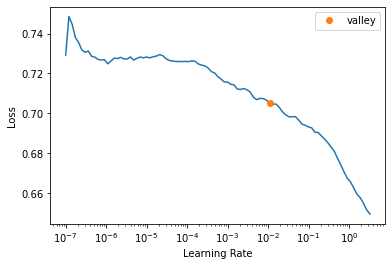

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,recall_score,precision_score,f1_score,time
0,0.529531,0.519559,0.787141,0.212859,0.699080,0.826087,0.757295,03:09
1,0.518012,0.508882,0.799001,0.200999,0.741130,0.818578,0.777931,03:15
2,0.508473,0.503645,0.796504,0.203496,0.743758,0.812052,0.776406,03:17
3,0.488769,0.491422,0.817104,0.182896,0.745072,0.851351,0.794674,03:15
4,0.477839,0.480401,0.832085,0.167915,0.745072,0.883178,0.808268,03:14
5,0.467437,0.478027,0.831461,0.168539,0.726675,0.899187,0.803779,03:14
6,0.454248,0.465370,0.844569,0.155431,0.751643,0.905063,0.821249,03:13
7,0.444745,0.449540,0.857054,0.142946,0.789750,0.897015,0.839972,03:14
8,0.434894,0.438770,0.872035,0.127965,0.810775,0.910029,0.857540,03:15
9,0.432139,0.434121,0.878277,0.121723,0.830486,0.905444,0.866347,03:14


Better model found at epoch 0 with f1_score value: 0.7572953736654805.


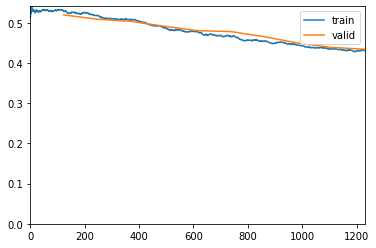

Better model found at epoch 1 with f1_score value: 0.7779310344827587.
Better model found at epoch 3 with f1_score value: 0.7946741415557113.
Better model found at epoch 4 with f1_score value: 0.8082679971489666.
Better model found at epoch 6 with f1_score value: 0.8212491026561378.
Better model found at epoch 7 with f1_score value: 0.8399720475192174.
Better model found at epoch 8 with f1_score value: 0.857539958304378.
Better model found at epoch 9 with f1_score value: 0.866346812885538.


epoch,train_loss,valid_loss,accuracy,error_rate,recall_score,precision_score,f1_score,time
0,0.423304,0.434888,0.877653,0.122347,0.823916,0.910015,0.864828,03:11
1,0.424256,0.434753,0.876405,0.123595,0.817346,0.913363,0.862691,03:08
2,0.419584,0.431756,0.879526,0.120474,0.823916,0.913994,0.866621,03:07
3,0.417439,0.434840,0.876405,0.123595,0.816032,0.914580,0.862500,03:08
4,0.419822,0.433249,0.877653,0.122347,0.818660,0.914831,0.864078,03:08
5,0.418009,0.430538,0.882023,0.117978,0.827858,0.915698,0.869565,03:08
6,0.414277,0.430755,0.880150,0.119850,0.822602,0.916545,0.867036,03:08
7,0.413112,0.432779,0.878277,0.121723,0.819974,0.914956,0.864865,03:07
8,0.413503,0.433768,0.878277,0.121723,0.816032,0.918639,0.864301,03:09


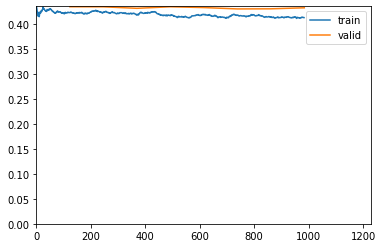

Better model found at epoch 2 with f1_score value: 0.8666205943331029.
Epoch 4: reducing lr to 4.065855285558782e-06
Better model found at epoch 5 with f1_score value: 0.8695652173913043.
Epoch 7: reducing lr to 9.484581765546326e-07
No improvement since epoch 5: early stopping


In [ ]:
learn.fine_tune(10,1e-04,10)

In [ ]:
stratified_df = pd.concat([df[df["is_clicked"] == True].reset_index(drop=True)[0:30000],
                           df[df["is_clicked"] == False].reset_index(drop=True)[0:30000]]).reset_index(drop=True).sample(frac=1)

stratified_df["is_valid"] = False
stratified_df["is_valid"] = stratified_df["is_valid"].apply(lambda x: True if random.random() < 0.08 else False)


train_ds1 = MixDataSet(stratified_df[stratified_df["is_valid"]==False],
                      cat_cols,
                      cont_cols,
                      "raw_query",
                      "products.category_name",
                      "products.product_name_normalized",
                      target_col_name="is_clicked",
                      vocab=vocab[0])

valid_ds1 = MixDataSet(stratified_df[stratified_df["is_valid"]==True],
                      cat_cols,
                      cont_cols,
                      "raw_query",
                      "products.category_name",
                      "products.product_name_normalized",
                      target_col_name="is_clicked",
                      vocab = vocab[0])

train_dl1 = DataLoader(dataset=train_ds1, batch_size=200, shuffle=True, collate_fn=my_collate)
valid_dl1 = DataLoader(dataset=valid_ds1, batch_size=200, shuffle=True, collate_fn=my_collate)


fast_mix_dl1 = DataLoaders(train_dl1,valid_dl1)

loss_func = nn.CrossEntropyLoss()

learn = Learner(fast_mix_dl1,
                mix_model,
                loss_func = loss_func,
                path = mix_model_path,
                metrics=[accuracy,error_rate,Recall(),Precision(),F1Score()]).to_fp16()

grp = ShowGraphCallback
svm = SaveModelCallback(at_end=False,every_epoch=False,reset_on_fit=False,monitor='f1_score',fname="mix_model",)
esc = EarlyStoppingCallback(patience=3)
rlr = ReduceLROnPlateau(monitor="valid_loss",patience=2,factor=10,)
learn.add_cbs([grp,svm,esc,rlr,ModelResetter])
learn.cbs

(#9) [TrainEvalCallback,Recorder,ProgressCallback,MixedPrecision,ShowGraphCallback,SaveModelCallback,EarlyStoppingCallback,ReduceLROnPlateau,ModelResetter]

epoch,train_loss,valid_loss,accuracy,error_rate,recall_score,precision_score,f1_score,time
0,0.514854,0.509429,0.794348,0.205652,0.836692,0.766244,0.799920,10:32
1,0.504958,0.488789,0.817863,0.182137,0.855584,0.790842,0.821940,10:36
2,0.486483,0.476250,0.830652,0.169348,0.850966,0.813077,0.831590,10:33


Better model found at epoch 0 with f1_score value: 0.799919727072045.


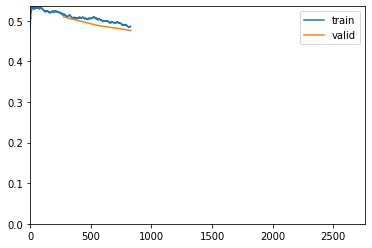

Better model found at epoch 1 with f1_score value: 0.8219399072393628.
Better model found at epoch 2 with f1_score value: 0.8315897435897436.


epoch,train_loss,valid_loss,accuracy,error_rate,recall_score,precision_score,f1_score,time
0,0.514854,0.509429,0.794348,0.205652,0.836692,0.766244,0.799920,10:32
1,0.504958,0.488789,0.817863,0.182137,0.855584,0.790842,0.821940,10:36
2,0.486483,0.476250,0.830652,0.169348,0.850966,0.813077,0.831590,10:33
3,0.482583,0.465288,0.845916,0.154084,0.879933,0.819711,0.848755,10:35
4,0.469866,0.457942,0.852104,0.147896,0.869857,0.835821,0.852499,10:44
5,0.461240,0.448700,0.862211,0.137789,0.866499,0.855012,0.860717,10:56
6,0.452145,0.441798,0.870668,0.129332,0.890008,0.853119,0.871173,10:56
7,0.446972,0.439227,0.872319,0.127682,0.869018,0.870846,0.869931,10:53
8,0.442604,0.436000,0.875619,0.124381,0.873216,0.873583,0.873399,10:45
9,0.436599,0.432439,0.878300,0.121700,0.871537,0.879661,0.875580,10:51


Better model found at epoch 3 with f1_score value: 0.8487548086657218.


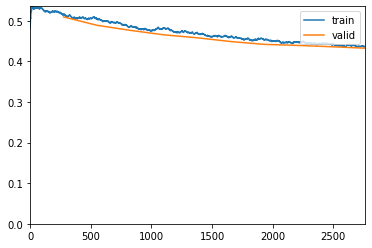

Better model found at epoch 4 with f1_score value: 0.8524994857025302.
Better model found at epoch 5 with f1_score value: 0.860717264386989.
Better model found at epoch 6 with f1_score value: 0.8711732073145675.
Better model found at epoch 8 with f1_score value: 0.8733991182028134.
Better model found at epoch 9 with f1_score value: 0.8755799240826655.


epoch,train_loss,valid_loss,accuracy,error_rate,recall_score,precision_score,f1_score,time
0,0.428294,0.430306,0.881394,0.118606,0.873216,0.883978,0.878564,10:50
1,0.429551,0.429422,0.882426,0.117574,0.868598,0.889510,0.878929,10:53


Better model found at epoch 0 with f1_score value: 0.8785638859556494.


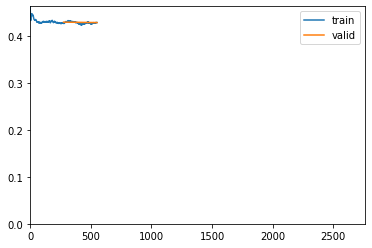

Better model found at epoch 1 with f1_score value: 0.87892948173322.


In [ ]:
learn.fine_tune(10,1e-04,10)